In [1]:
import sys

sys.path.append('core')

# import argparse
import glob
import os
import math

import cv2
import numpy as np
import torch
from PIL import Image
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from PIL import Image

from flow_utils import generate_warped_image, get_color_wheel_distance

DEVICE = 'cuda'

def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)


def flow_visualization(img1, img2, flo, idx, model_name, plot=False,
                        compute_distance=False, warp=False
    ):
    combine_img_flow = False
    img1 = img1[0].permute(1,2,0).cpu().numpy()
    img2 = img2[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()

    # map flow to rgb image
    flo_rgb = flow_viz.flow_to_image(flo) # correct RGB order
    return flo_rgb

    """
    if combine_img_flow:
        img_flo = np.concatenate([img1, flo_rgb], axis=0)
        if 'kitti' in model_name:
            folder_name = 'out_kitti'
        elif 'sintel' in model_name:
            folder_name = 'out_sintel'
        elif 'chairs' in model_name:
            folder_name = 'out_chairs'
        elif 'things' in model_name:
            folder_name = 'out_things'
        elif 'small' in model_name:
            folder_name = 'out_small'
        filename = f'{folder_name}/{idx}.png'
        # cv2.imwrite(f'img_flo/{idx}.jpg', img_flo[:, :, [2,1,0]])

    if warp:
        # print('Generating warped image...')
        warped_img, residual = generate_warped_image(flo, img1, img2, idx)
        photometric_error = np.mean(residual)
        # combine_pred_target = np.concatenate([img2, warped_img], axis=0)
        cv2.imwrite(f'warp/{idx}.jpg', warped_img)
        cv2.imwrite(f'residual/{idx}.jpg', residual)

    if compute_distance:
        flo_dist = get_color_wheel_distance(flo_rgb, idx)

    if plot:
        pme = str(round(photometric_error,2))
        # save_plot(img1, img2, flo_dist, warped_img, residual, pme, idx)
        cv2.imwrite(f'flow/{idx}.jpg', flo_dist)

    return pme
    """


def save_plot(img1, img2, flo_dist, warped_img, residual, photometric_error, idx):
    # print('Saving plot...')

    plt.figure(figsize = (5,1))
    plt.rcParams['font.size'] = 5
    gs1 = gridspec.GridSpec(1,5)
    gs1.update(wspace=0.35, hspace=0.25) # set the spacing between axes.
    to_plot = [img1, img2, warped_img, residual, flo_dist[:,:,[2,1,0]]]
    plot_labels = ['Previous Frame', 'Current Frame', 'Warped Frame', \
        f'Residual\n[Photometric\nError: {photometric_error}]', 'Flow visualization'
    ]
    for i in range(5):
        ax = plt.subplot(gs1[i])
        ax.imshow(to_plot[i]/255.0)
        ax.set_title(plot_labels[i])
        ax.axis('off')
        ax.set_aspect('equal')

    plt.savefig(f'results/{idx}.jpg', dpi=480, bbox_inches='tight', pad_inches=0.1)
    

In [2]:
class Args:
    def __init__(self):
        self.model = 'models/raft-things.pth'
        self.path = '../dataset'
        self.small = False
        self.mixed_precision = False
        self.alternate_corr = False
        self.dropout = False
args = Args()

model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))

model = model.module
model.to(DEVICE)
model.eval()

with torch.no_grad():
    images = glob.glob(os.path.join(args.path, '*.png')) + \
             glob.glob(os.path.join(args.path, '*.jpg'))

    images = sorted(images)
    prev_frames = images[:-1]
    curr_frames = images[1:]
    i=0
    
    for imfile1, imfile2 in zip(prev_frames, curr_frames):
        image1 = load_image(imfile1)
        image2 = load_image(imfile2)

        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)

        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
        flow_visualization(image1, image2, flow_up, i, model_name=args.model,
            plot=False, compute_distance=False, warp=False
        )
        i += 1
        break


/scratch/rr3937/envs_dirs/craft/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
flow_up.shape

torch.Size([1, 2, 1024, 1024])

In [4]:
img1, img2, flo = image1, image2, flow_up
img1 = img1[0].permute(1,2,0).cpu().numpy()
img2 = img2[0].permute(1,2,0).cpu().numpy()
flo = flo[0].permute(1,2,0).cpu().numpy()

# map flow to rgb image
flo_rgb = flow_viz.flow_to_image(flo) # correct RGB order

In [5]:
flo_rgb.shape

(1024, 1024, 3)

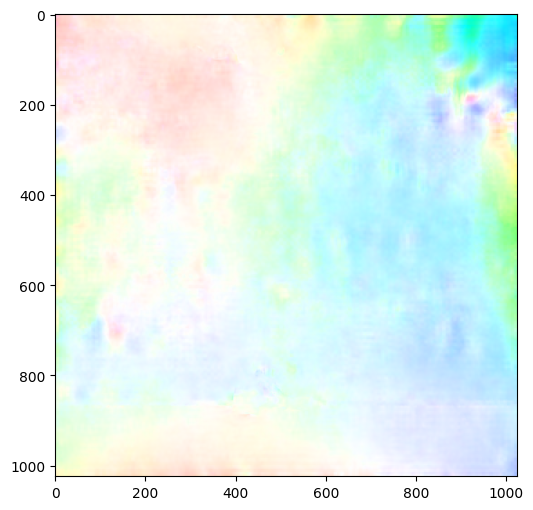

In [6]:
fig, ax = plt.subplots(1, figsize=(12,6))
annot_x = (plt.xlim()[1] + plt.xlim()[0])/2
annot_y = (plt.ylim()[1] + plt.ylim()[0])/2
# txt = ax.text(annot_x, annot_y, "Chart Ready", 
#               ha='center', fontsize=36, color='#DD4012')
def hover(event):
    txt.set_text("")
fig.canvas.mpl_connect("motion_notify_event", hover)
plt.imshow(flo_rgb)

In [2]:
# !pip install ipympl

In [ ]:
# !pip uninstall numpy
# !pip install numpy==1.23.1

In [9]:
# import matplotlib.pyplot as plt
# import pandas as pd
%matplotlib widget

In [7]:
import pandas as pd

In [10]:
# import pandas as pd
df = pd.read_csv('world-happiness-report-2021.csv')
# df = df[df['year'] == 2020]
x_name = 'Healthy life expectancy'
y_name = 'Freedom to make life choices'
tooltip_name = 'Country name'
x = df[x_name]
y = df[y_name]
tt = df[tooltip_name].values
# df

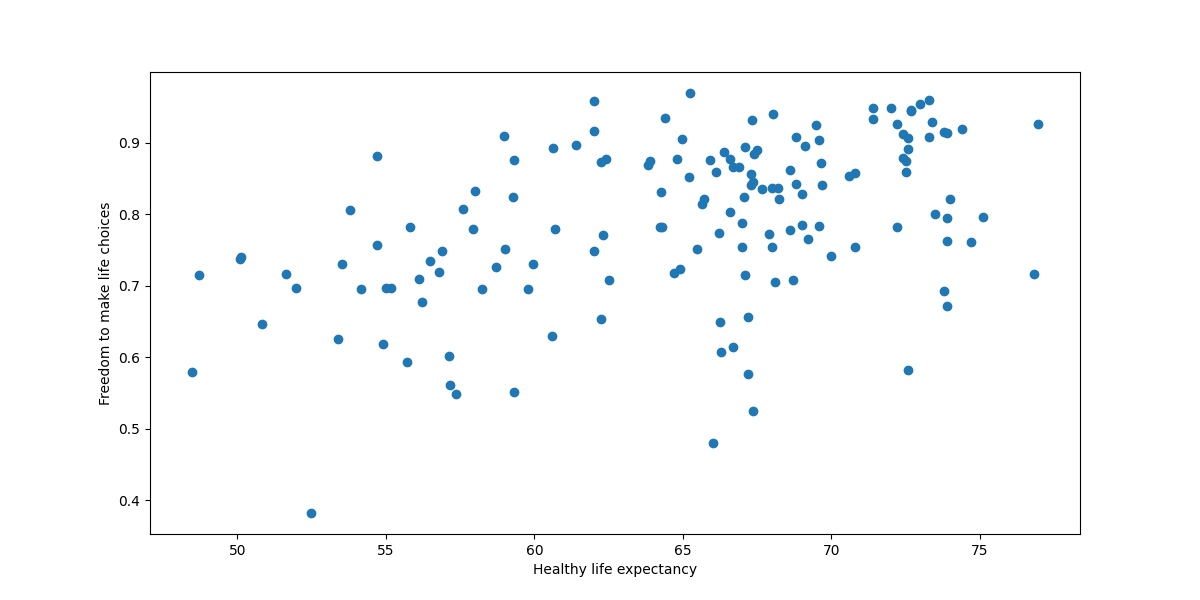

In [11]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.scatter(x, y)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

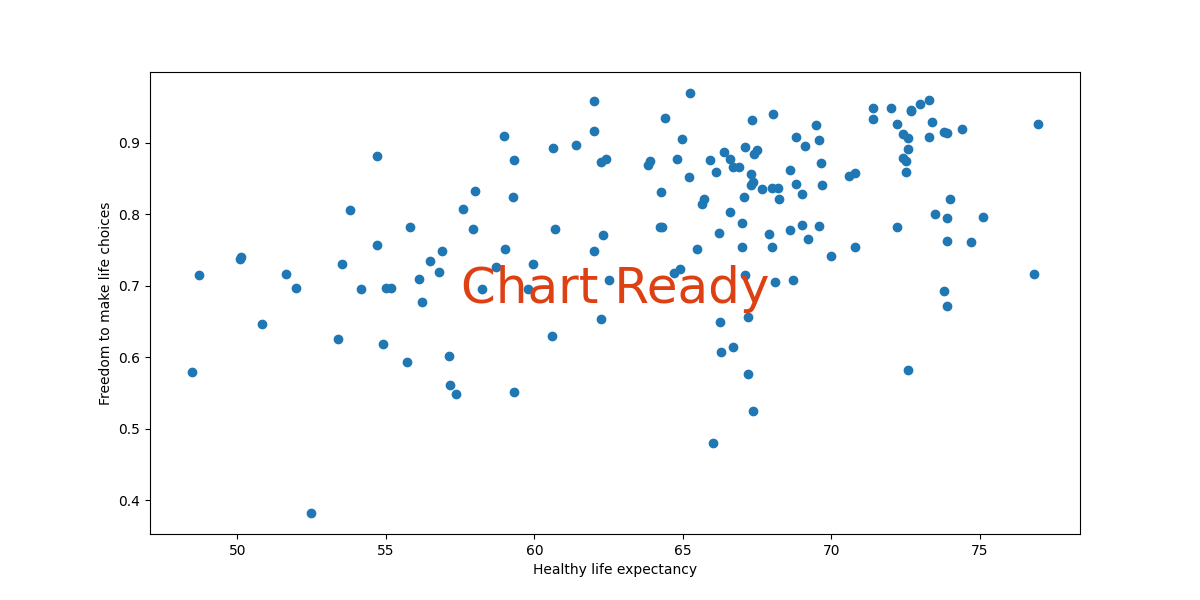

In [12]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.scatter(x,y)
plt.xlabel(x_name)
plt.ylabel(y_name)
annot_x = (plt.xlim()[1] + plt.xlim()[0])/2
annot_y = (plt.ylim()[1] + plt.ylim()[0])/2
txt = ax.text(annot_x, annot_y, "Chart Ready", 
              ha='center', fontsize=36, color='#DD4012')
def hover(event):
    txt.set_text("")
fig.canvas.mpl_connect("motion_notify_event", hover)
plt.show()

In [13]:
# importing the module
import cv2

# function to display the coordinates of
# of the points clicked on the image
def click_event(event, x, y, flags, params):

	# checking for left mouse clicks
	if event == cv2.EVENT_LBUTTONDOWN:

		# displaying the coordinates
		# on the Shell
		print(x, ' ', y)

		# displaying the coordinates
		# on the image window
		font = cv2.FONT_HERSHEY_SIMPLEX
		cv2.putText(img, str(x) + ',' +
					str(y), (x,y), font,
					1, (255, 0, 0), 2)
		cv2.imshow('image', img)

	# checking for right mouse clicks	
	if event==cv2.EVENT_RBUTTONDOWN:

		# displaying the coordinates
		# on the Shell
		print(x, ' ', y)

		# displaying the coordinates
		# on the image window
		font = cv2.FONT_HERSHEY_SIMPLEX
		b = img[y, x, 0]
		g = img[y, x, 1]
		r = img[y, x, 2]
		cv2.putText(img, str(b) + ',' +
					str(g) + ',' + str(r),
					(x,y), font, 1,
					(255, 255, 0), 2)
		cv2.imshow('image', img)

# driver function
if __name__=="__main__":

	# reading the image
	img = cv2.imread('RAFT.png', 1)

	# displaying the image
	cv2.imshow('image', img)

	# setting mouse handler for the image
	# and calling the click_event() function
	cv2.setMouseCallback('image', click_event)

	# wait for a key to be pressed to exit
	cv2.waitKey(0)

	# close the window
	cv2.destroyAllWindows()


error: OpenCV(4.7.0) /io/opencv/modules/highgui/src/window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [15]:
# !pip install mpldatacursor

639.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Textarea(value='ok', description='event:', disabled=True, placeholder='')

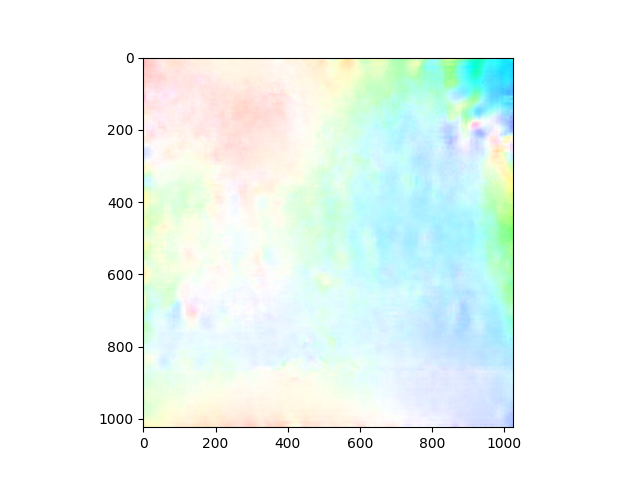

In [49]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg  # Using the ipython notebook widgets

a = flo_rgb #flow_up.cpu().squeeze(0).permute(1,2,0)
fig = plt.figure()
plt.imshow(a)

# Create and display textarea widget
txt = wdg.Textarea(
    value='ok',
    placeholder='',
    description='event:',
    disabled=True
)
display(txt)

# Define a callback function that will update the textarea
event = None
def onclick(event):
    # x = event.button_press_event.xydata
    # ix, iy = event.xdata, event.ydata
    # txt.value = str(event)  # Dynamically update the text box above
    txt.value = str(flow_up[0][10][20])

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)

In [44]:
dir(event.xydata)

AttributeError: 'NoneType' object has no attribute 'xydata'

In [23]:
flow_up.squeeze(0).permute(1,2,0).shape

torch.Size([1024, 1024, 2])

/state/partition1/job-30515628/ipykernel_3791193/34756387.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


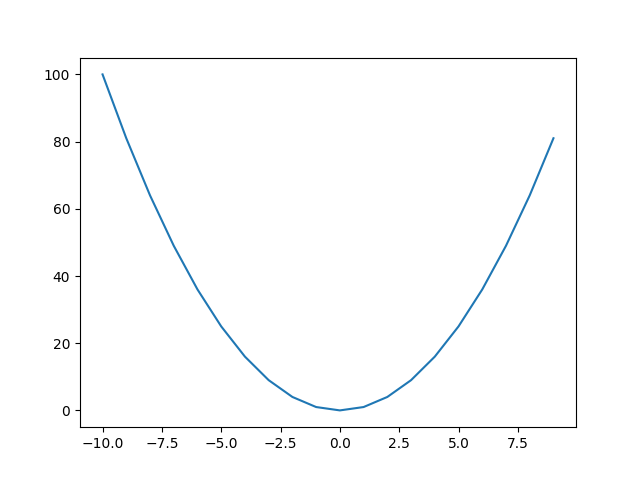

In [37]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-10,10)
y = x**2

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,y)

coords = []

def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print (f'x = {ix}, y = {iy}')

    global coords
    coords.append((ix, iy))
    
    if len(coords) == 2:
        fig.canvas.mpl_disconnect(cid)

    return coords
cid = fig.canvas.mpl_connect('button_press_event', onclick)